# Home assignement 3: Stochastic models

This tutorial illustrates the manipulation of stochastic models and signals.

## Part 1: Processing and spectral analysis of Local Field Potentials
Local Field Potentials (LFPs) designate the "low" frequency part of the electrical potential in the extracellular medium of the brain, typically below 200Hz. It reflects many network processes, and is assumed to be generated, to a large extended, by post-synaptic currents entering the neurons.

Let us load some exemplary data recoded from the macaque hippocampus that you can dowload from https://owncloud.tuebingen.mpg.de/index.php/s/REc82bzpCetG27T (update the dataPath variable below before loading). The variable ```LFP``` will store the LFP time series, ```dt``` the sampling period, and ```t``` the associated time axis.

In [1]:
# to display all outputs of a cell
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

# load local field potential
dataPath = '.\\'
from scipy import io
import numpy as np
import matplotlib.pyplot as plt

lfpdat = io.loadmat(dataPath+"LFPdat.mat")

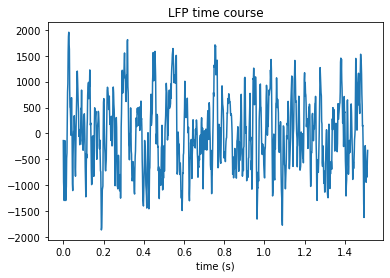

In [2]:
# Define LFP time series
LFP = lfpdat['LFP'][:,0]
# Define sampling period dt (sampling frequency is 660Hz)
dt = lfpdat['dt'][:,0]
t = np.arange(LFP.shape[0])*dt

# we plot only the begining of the recording
plt.plot(t[0:1000],LFP[0:1000])
plt.title('LFP time course')
plt.xlabel('time (s)')
plt.show()

In [3]:
print(max(t))

600.023423451829


We want to estimate the Power Spectral Density of the LFP signal. We use the scipy.signal.welch function for this purpose. 

In [4]:
from scipy.signal import welch
help(welch)

Help on function welch in module scipy.signal.spectral:

welch(x, fs=1.0, window='hann', nperseg=None, noverlap=None, nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=-1, average='mean')
    Estimate power spectral density using Welch's method.
    
    Welch's method [1]_ computes an estimate of the power spectral
    density by dividing the data into overlapping segments, computing a
    modified periodogram for each segment and averaging the
    periodograms.
    
    Parameters
    ----------
    x : array_like
        Time series of measurement values
    fs : float, optional
        Sampling frequency of the `x` time series. Defaults to 1.0.
    window : str or tuple or array_like, optional
        Desired window to use. If `window` is a string or tuple, it is
        passed to `get_window` to generate the window values, which are
        DFT-even by default. See `get_window` for a list of windows and
        required parameters. If `window` is array_l

This function cuts the input time series in overalpping segments, computes the squared Fourier transform of each to estimate the periodogram by averaging, as seen in the lecture. 

First, let us use a deterministic continuous time model: we assume continuous time signal $x(t)$ is analyzed spectrally on a finite duration interval $[-T/2,T/2]$ by computing the squared Fourier transform of the pointwise product of $x(t/T)$, using a tappering window $w(t)$ such that $w(t)=0$ for $|t|>1/2$. 

**Important: plot all periodograms with a physical frequency axis (Hz)**

**Question 1:**
 - (a) (2 points) Compute the analytical expression of the continuous time Fourier transform of the pointwise product $$
 \frac{1}{T}{x(t)\cdot w(t/T)}\,,
 $$ 
 as a function of $T$ and the Fourier transforms of $x$ and $w$. 


<img src="q1a.jpg" align="left" width=800 height=600 />

 - (b) (2 points, optional) What is the limit of this function for $T$ very small and $T$ very large? Justify qualitatively or using distributions.
 

<img src="q1b.jpg" align="left" width=800 height=600 />

- (c) (2 points) The "nperseg" controls the width (number of points of the segments) used by the algorithm to compute a single DFT (with the FFT algorithm), proportional to $T$ in the continuous time model. Compute and plot the periodogram of the LFP signal for $T=1s$. What is the dominant frequency in this signal?

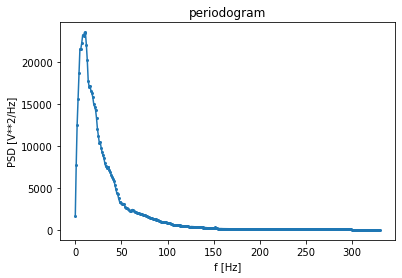

In [5]:
# compute PSD
f_LFP, Pxx_LFP = welch(LFP, fs=1/dt, nperseg=1/dt)

plt.figure(figsize=(6,4))
plt.plot(f_LFP, Pxx_LFP, '-o', markersize=2)
plt.xlabel('f [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.title('periodogram')
plt.show()

In [6]:
print('The periodogram peaks at' , f_LFP[np.argmax(Pxx_LFP)], 'Hz')

The periodogram peaks at 10.000013649007379 Hz


The dominant frequency is between 0 to 10 Hz, with peak power spectrum density at 2 Hz.

 - (d) (2 points) The time resoved power in the so called gamma band (typically between 60 and 120Hz) of the LFP has been reported to reflect the amount of recurrent activity in the network, and is related to the BOLD signal measured in fMRI (see part 3). Perform the following operations to extract this time resolved power: 
   - filter the LFP in the [60,120Hz] band with a Butterworth filter to obtain signal $g$ (use scipy.signal.filtfilt to apply a zero phase filter), 
   - take the square of $g$, $g^2$, 

   - low pass filter $g^2$ below $60Hz$ to get $g_{pow}$ the time resolved gamma power. 
   For each signal (LFP,$g$ ,$g^2$,$g_{pow}$), estimate the PSD with the Welch periodogram and plot it, using $T=1s$

In [7]:
from scipy.signal import filtfilt, butter, hilbert

Text(0.5, 1.0, 'periodogram g_pow')

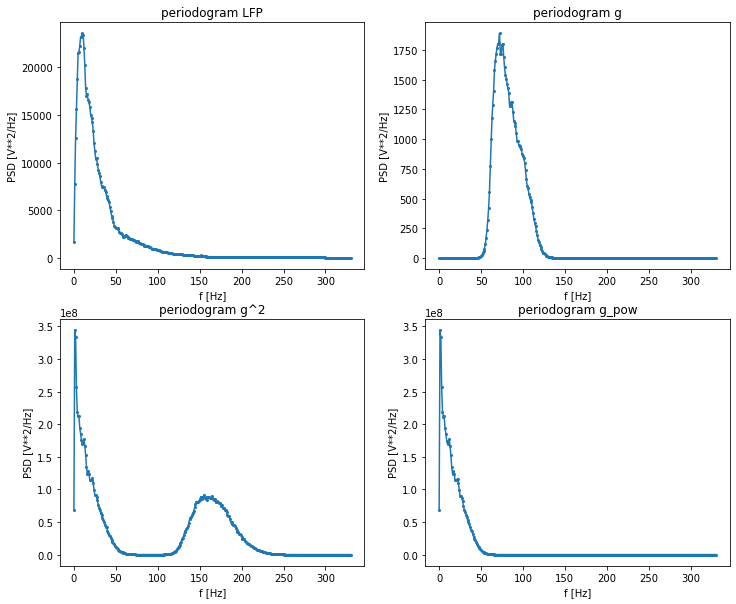

In [8]:
# find g, g**2, g_pow
fs = 1/dt
nyq = fs/2 
f_band = [60,120]
order = 3
b, a = butter(order, f_band/nyq, btype='bandpass') 
g = filtfilt(b, a, LFP)
f_low = 60
b, a = butter(order, f_low/nyq, btype='lowpass') 
g_pow = filtfilt(b, a, g**2)

# estimate PSD
f_LFP, Pxx_LFP = welch(LFP, fs=1/dt, nperseg=1/dt)
f_g, Pxx_g = welch(g, fs=1/dt, nperseg=1/dt)
f_g_sqr, Pxx_g_sqr = welch(g**2, fs=1/dt, nperseg=1/dt)
f_g_pow, Pxx_g_pow = welch(g_pow, fs=1/dt, nperseg=1/dt)

# plot
plt.figure(figsize=(12,10))
plt.subplot(221)
plt.plot(f_LFP, Pxx_LFP, '-o', markersize=2)
plt.xlabel('f [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.title('periodogram LFP')
plt.subplot(222)
plt.plot(f_g, Pxx_g, '-o', markersize=2)
plt.xlabel('f [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.title('periodogram g')
plt.subplot(223)
plt.plot(f_g_sqr, Pxx_g_sqr, '-o', markersize=2)
plt.xlabel('f [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.title(r'periodogram g^2')
plt.subplot(224)
plt.plot(f_g_pow, Pxx_g_pow, '-o', markersize=2)
plt.xlabel('f [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.title(r'periodogram g_pow')

 - (d) (2 points) Given that the periodogram reflects (to some extent, see lecture) the expected squared modulus of the Fourier transform of signal realisations, justify qualitatively the shape taken by the successive PSDs (why particular frequencies appear or are preserved/removed...).

1. the LFP was filtered with a 60 Hz - 120Hz bandpass filter to obtain g. So in the periodogram of g, most power density  was concentrated between 60 Hz and 120 Hz.
2. In the periodogram of g^2 a blob between 0-60 Hz and 120-240 Hz appeared. Because g mainly consists signals of frequency 60 to 120 Hz, so g could be written as $g(x) = \sum_{n} c_n e^{i2 \pi n x}$, where the coefficient c_n >>0 for $|n| \in [ 60, 120]$ Hz. So, $g^2(x) =  \big(\sum_{n} c_n e^{i2 \pi n x}\big)\big( \sum_{m} c_m e^{i2 \pi m x}\big) $, where the coefficient >>0 for $|n|,|m| \in [ 60, 120]$ Hz.<br>
$
\begin{align*}
g^2(x) &=  \big(\sum_{n} c_n e^{i2 \pi n x}\big)\big( \sum_{m} c_m e^{i2 \pi m x}\big)\\
&=\sum_{n}\sum_{m}c_n\cdot c_m \cdot e^{i2 \pi (n+m) x}
\end{align*}
$<br>
in $g^2(x), |m+n| \in [0,60] \cup [120,240] Hz$, which then give rise to the two blobs in the periodogram. 
3. g^2(x) was low pass filtered at 60 Hz to get g_pow, so in the periodogram of g_pow the low frequency blob [0,60] Hz was  preserved and the high frequency blob [120,240]Hz was removed.

 - (e) (1 point, optional) Plot the square root of $g_{pow}$ on a short interval (1s) and check visually it follows the enveloppe of oscillations in $g$ correctly.

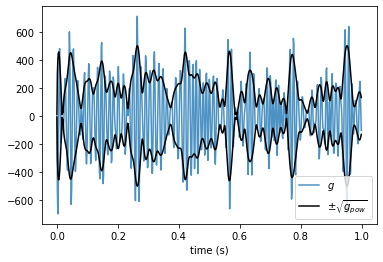

In [9]:
g_root = np.sqrt(abs(g_pow))

plt.figure(figsize=(6,4))
plt.plot(t[0:660],g[0:660], alpha=.8, label='$g$')
plt.plot(t[0:660],g_root[0:660],'k',label='$\pm\sqrt{g_{pow}}$')
plt.plot(t[0:660],-g_root[0:660],'k')
plt.xlabel('time (s)')
plt.legend()
plt.show()

 - (f) (2 points) The phase of $g(t)$ has been hypothesized to be important for organizing neural computation, in order to extract this information, compute the analytic signal associated to $g$ using the scipy.signal.hilbert function. Plot the trajectory of the analytic signal in the complex plane on a short interval of 1s, check visually that the vector operates regular rotations around the origin. Plot the argument of the analytic signal as a function of time: check visually that the values are compuatible with an interpretation as the phase of the original oscillatory signal $g(t)$.
 
 

Text(0.5, 1.0, 'argument of the analytic signal as a function of time')

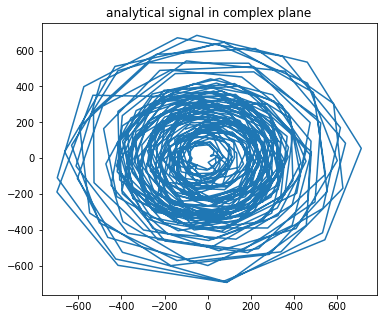

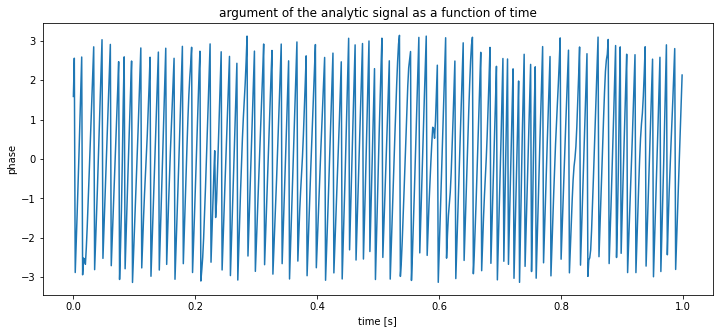

In [10]:
analytical_g = hilbert(g)

# plot
plt.figure(figsize=(6,5))
plt.plot(analytical_g[0:660].real,analytical_g[0:660].imag)
plt.title('analytical signal in complex plane')

plt.figure(figsize=(12,5))
t = np.arange(660)*dt
plt.plot(t,np.angle(analytical_g[0:660]))
plt.xlabel('time [s]')
plt.ylabel('phase')
plt.title('argument of the analytic signal as a function of time')

## Part 2: A LTI model of neurovascular coupling

Functional Magnetic Resonance Imaging measures the Blood Oxygen Level Dependent (BOLD) signal related to the concentration of oxyhemoglobin in the brain tissue and is used to assess functional brain activity. 

While the link between neural activity and BOLD is complex, involving several non-linear phenomena, and still elusive, the fMRI community has since long used a linear time invariant system to model this relation. The impulse response of this model is called the Hemodynamic Response Function (HRF), and can be used to investiagte properties of neural activity based on fMRI measurements.

### Reference HRF
We first define a reference HRF in continuous time, similar to those used in popular software such as SPM (https://www.fil.ion.ucl.ac.uk/spm/).

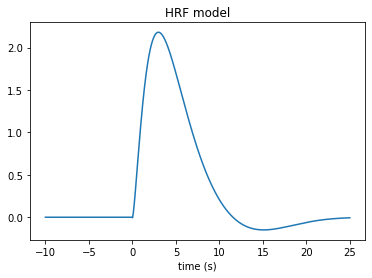

In [11]:
import scipy.stats as stats

def hrf(t):
    pars = [2.5, 2.02, 14.5, 0.247]
    resp = pars[2]*stats.gamma.pdf(t,pars[0],scale = pars[1])-pars[3]*np.exp(-(t-25/2)**2/(12/1.8)**2)
    resp[t<0] = 0
    return resp

t= np.arange(-10,25,.01)

plt.plot(t,hrf(t))
plt.title('HRF model')
plt.xlabel('time (s)')
plt.show()

### LFP based model

As an approximation for the neural activity, i.e. the input of the HRF-based model, we can take the time resolved gamma band power $g_d$ computed above. You can check this papers for further details:
https://www.ncbi.nlm.nih.gov/pubmed/11449264
https://www.jneurosci.org/content/32/4/1395

Let us load a downsampled version of the previously computed gamma power signal available at https://owncloud.tuebingen.mpg.de/index.php/s/3HN9jAmGW7miZ4t, sampled at approximately 132Hz (1/dt). We will also remove the mean and normalize the amplitude for simplicity. We will now call this normalized input signal $x$.

Text(0.5, 0, 'time (s)')

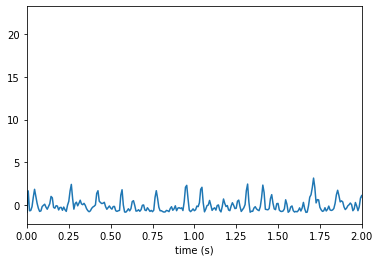

In [12]:
gpow = np.load(dataPath+'\\gammaPower.npz')
x = gpow['x']
x = x -np.mean(x)
x = x/np.std(x)
dt = gpow['dt']
t = np.arange(len(x))*dt
plt.plot(t,x)
plt.xlim([0,2])
plt.gca().set_xlabel('time (s)')

In [13]:
print(max(t))
print(1/dt)

600.0219083023819
[132.00018017]


We use the *hrf* function to sample the impulse response at the sampling frequency of the above downsampled signal $x(t)$ (at approximately 132Hz). Note the impulse response is causal (values before $t=0$ are zero). We can thus sample the hrf on an interval [0,25s]. We will use this sampled HRF, that we will call $h$ to compute an estimate $y$ of the BOLD signal.

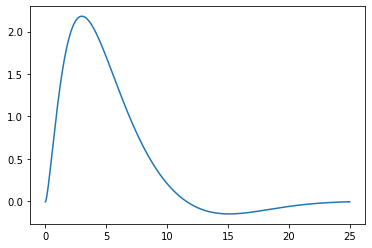

In [14]:
tsamp = np.arange(0,25,dt)
h = hrf(tsamp)
plt.plot(tsamp,h)

In [15]:
from statsmodels.tsa.stattools import acovf,ccovf
ccovf?

We will use the following function to compute de cross-correlation between stationnary signals $X[t]$ and $Y[t]$, $\gamma_{XY}(\tau)$ as defined in the lecture:
$$
\gamma_{XY}(\tau) = \mathbb{E}[X[0]Y[\tau]]
$$

In [16]:
def crossCorr(X, Y, maxLag):
    """
    Returns the cross covariance between X and Y up to maximum lag maxLag:
    Arguments:
    - X: first time series,
    - Y: second time series,
    - maxLag: integer maximum lag
    Outputs:
    - corxy: crosscorrelation function
    - tau: lag axis (from -maxLag to +maxLag)
    
    """
    posCor = ccovf(Y,X,unbiased=False)
    negCor = ccovf(X,Y,unbiased=False)
    corxy = np.concatenate([negCor[-1:0:-1],posCor])
    lags = np.arange(-len(negCor)+1,len(posCor))
    idxLag = np.abs(lags)<=maxLag
    tau = lags[idxLag]
    corxy = corxy[idxLag]
    return corxy, tau


**Question 2**
 - (a) (1 point) Generate a simulated BOLD signal $y(t)$ by convolving the gamma power signal $x(t)$ by the sampled HRF $h$, and then adding a Gaussian white noise of variance 1. Plot the resulting simulated BOLD signal.
 

In [17]:
y = np.convolve(x, h,'full')
y = y + np.random.normal(size=y.shape[0])


Text(0, 0.5, 'BOLD')

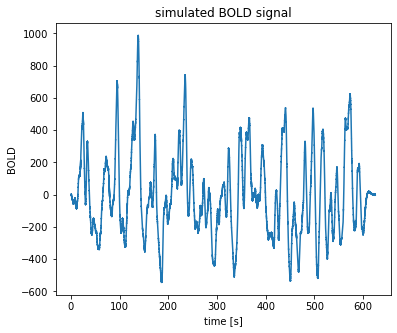

In [18]:
# plot
plt.figure(figsize=(6,5))
t = np.arange(len(y))*dt
plt.plot(t,y)
plt.title('simulated BOLD signal')
plt.xlabel('time [s]')
plt.ylabel('BOLD')

 - (b) (2 points) Compute and plot the autocovariance functions of $x(t)$ and $y(t)$, and the cross-covariance $\gamma_{xy}$  between them for a lag axis of [-40,40] **seconds** (normalize their amplitude to their respective maximum to allow comparison on the same graph). Justify the location of the maxima of the two functions.
 
 

In [19]:
# calculate autocovariance and crosscovariance
corxx, tau = crossCorr(x, x, maxLag=40/dt)
coryy, tau = crossCorr(y, y, maxLag=40/dt)
corxy, tau = crossCorr(np.pad(x, (0,len(y)-len(x)),'constant'),y, maxLag=40/dt)


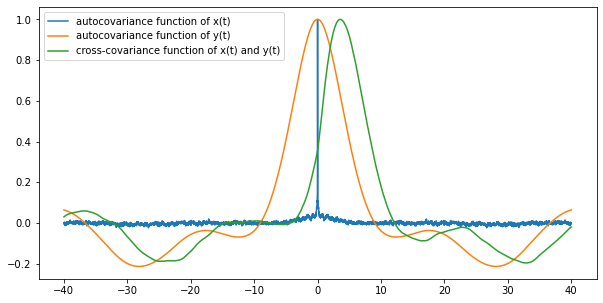

In [20]:
# plot
plt.figure(figsize=(10,5))
plt.plot(tau*dt,corxx/max(corxx),label=r'autocovariance function of x(t)')
plt.plot(tau*dt,coryy/max(coryy),label=r'autocovariance function of y(t)')
plt.plot(tau*dt,corxy/max(corxy),label=r'cross-covariance function of x(t) and y(t)')
plt.legend()

In [21]:
print('autocovariance function of x(t) peaks at: ',(np.argmax(corxx)-(len(corxx)-1)/2)*dt, 's')
print('autocovariance function of y(t) peaks at: ',(np.argmax(coryy)-(len(coryy)-1)/2)*dt, 's')
print('cross-covariance function of x(t) and y(t) peaks at: ',(np.argmax(corxy)-(len(corxy)-1)/2)*dt, 's')
print('h peaks at: ',np.argmax(h)*dt, 's')

autocovariance function of x(t) peaks at:  [0.] s
autocovariance function of y(t) peaks at:  [0.] s
cross-covariance function of x(t) and y(t) peaks at:  [3.56817695] s
h peaks at:  [2.99242016] s


correlation is a measure of similarity between two signals, so auto-correlation (auto-covariance) always peaks at lag=0.<br>
x could be seen as a weakly stationary stochastic processes so the auto-covariance peaks at lag = 0 and the values soon decrease to around 0 for other lag values.<br>
The cross-covariance doesn't peak at lag=0, because x and y are different, and y is the result of x convolving with h, plus some noise. h peaks at some positive value, so the covariance function between x and y also peaks at some positive lag.    

 - (c) (3 points) We aim at estimating the filter $h(t)$ based only on its input $x(t)$ and output $y(t)$. Use the cross-correlation function estimates to build the matrix $A$ and vector $d$ seen in lecture 8, slide 15 (identification of a FIR model). To construct $A$, you can check and use the *scipy.linalg.toeplitz* routine. For simplicity, choose the size of the maximum delay $p$ that corresponds to the length of the true sampled HRF $h$.
 

In [22]:
from scipy.linalg import toeplitz

In [23]:
p = len(h)
tau0 = list(tau).index(0)
A = toeplitz(corxx[tau0:tau0+p], corxx[tau0:tau0-p:-1])
d = corxy[tau0:tau0+p]

 - (d) (2 points) Solve the linear system $A\hat{h}=d$, using *scipy.linalg.solve*, in order to get an estimate $\hat{h}$ of $h$. Is the fit qualitatively good?
 

In [24]:
from scipy.linalg import solve

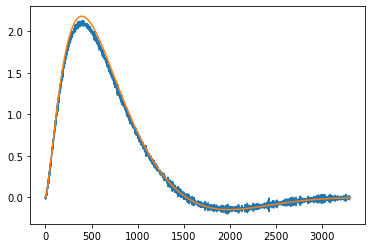

In [25]:
h_hat = solve(A,d)
plt.plot(h_hat)
plt.plot(h)

 - (e) (2 points) The original estimate was based on the full time course of the signals (600s). Quantify how varies the mean square error of the estimate of $h$ when we estimate auto- and cross-correlation functions only from on initial segment of data of $30$, $100$, and $200s$. 

In [26]:
def MSE_h_hat(x):
    # convolution
    y = np.convolve(x, h,'full')
    y = y + np.random.normal(size=y.shape[0])

    # calculate autocovariance and crosscovariance
    corxx, tauxx = crossCorr(x, x, maxLag=40/dt)
    coryy, tauyy = crossCorr(y, y, maxLag=40/dt)
    corxy, tauxy = crossCorr(np.pad(x, (0,len(y)-len(x)),'constant'),y, maxLag=40/dt)
    
    # estimate h_hat
    p = len(h)
    tauxx0 = list(tauxx).index(0)
    tauxy0 = list(tauxy).index(0)
    A = toeplitz(corxx[tauxx0:tauxx0+p], corxx[tauxx0:tauxx0-p:-1])
    d = corxy[tauxy0:tauxy0+p]
    h_hat = solve(A,d)

    # calculate MSE
    MSE = sum((h-h_hat)**2)/len(h)
    return MSE

In [27]:
print('MSE (full data):', MSE_h_hat(x))
print('MSE (200s):',MSE_h_hat(x[0:int(200/dt)]))
print('MSE (100s):',MSE_h_hat(x[0:int(100/dt)]))
print('MSE (30s):',MSE_h_hat(x[0:int(30/dt)]))

MSE (full data): 0.0017787410483894304
MSE (200s): 0.011250955032444611
MSE (100s): 0.03375846059135078
MSE (30s): 0.12937453140322172


The mean square error of the estimate of h decrease with longer segment of data.Full data gives the best estimate of h, with lowest MSE amongst all, while MSE with 30 s data is highest (worst estimate).  

### Granger causality analysis (optional)
The above simulated signal entails a clear causality from the gamma power $x(t)$ to the BOLD signal $y(t)$. We attempt to infer this causation from data with Granger causality. We use the statsmodels.tsa.stattools library for that.

In [28]:
from statsmodels.tsa.stattools import grangercausalitytests
grangercausalitytests?

In order to mimic realistic scenarios, and also to limit the computational load, we decimate the signals by decimating them by a factor ten (simply by using the subindexing operation ```x[::10]```). 

**Question 3** (2 points, optional)
Use the above Granger causality function to infer causation from $x(t)$ to $y(t)$ and from $y(t)$ to $x(t)$ based on the decimated signals. Make this test for one single lag, corresponding to the original duration of the hrf (25s) (use the input ```maxlag = [lag]``` for this computed lag). Use the result of the *ssr_chi2test* to assess significance. Do the results match the ground truth? 

In [36]:
xt = np.pad(x[::10], (0,len(y[::10])-len(x[::10])),'constant')
data_x_to_y = np.vstack((y[::10],xt)).T
data_y_to_x = np.vstack((xt,y[::10])).T
lag = int(25/10/dt)
resultxy = grangercausalitytests(data_x_to_y, [lag])
resultyx = grangercausalitytests(data_y_to_x, [lag])


Granger Causality
number of lags (no zero) 330
ssr based F test:         F=0.9319  , p=0.8029  , df_denom=7260, df_num=330
ssr based chi2 test:   chi2=335.5362, p=0.4051  , df=330
likelihood ratio test: chi2=328.6240, p=0.5110  , df=330
parameter F test:         F=0.9319  , p=0.8029  , df_denom=7260, df_num=330

Granger Causality
number of lags (no zero) 330
ssr based F test:         F=2.8744  , p=0.0000  , df_denom=7260, df_num=330
ssr based chi2 test:   chi2=1034.9067, p=0.0000  , df=330
likelihood ratio test: chi2=972.6657, p=0.0000  , df=330
parameter F test:         F=2.8744  , p=0.0000  , df_denom=7260, df_num=330


In [42]:
testx = x[::10]
lenx = len(testx)
testy = y[::10]
testy = testy[len(testy)-len(testx):]
data_x_to_y = np.vstack((testy,testx)).T
data_y_to_x = np.vstack((testx,testy)).T
lag = int(25/10/dt)
resultxy = grangercausalitytests(data_x_to_y, [lag])
resultyx = grangercausalitytests(data_y_to_x, [lag])


Granger Causality
number of lags (no zero) 330
ssr based F test:         F=0.9174  , p=0.8517  , df_denom=6930, df_num=330
ssr based chi2 test:   chi2=331.6085, p=0.4648  , df=330
likelihood ratio test: chi2=324.5697, p=0.5740  , df=330
parameter F test:         F=0.9174  , p=0.8517  , df_denom=6930, df_num=330

Granger Causality
number of lags (no zero) 330
ssr based F test:         F=2.8054  , p=0.0000  , df_denom=6930, df_num=330
ssr based chi2 test:   chi2=1014.0800, p=0.0000  , df=330
likelihood ratio test: chi2=951.8309, p=0.0000  , df=330
parameter F test:         F=2.8054  , p=0.0000  , df_denom=6930, df_num=330


Yes, it matches the ground truth, the Granger causality from x to y was more significant than that from y to x.